## Install dependencies

In [7]:
!pip install -U pythainlp openai-whisper transformers fairseq sacremoses matplotlib librosa

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.7 MB/s eta 0:00:00
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached importlib_resources-6.4.0-py3-none-any.whl.metadata (3.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 31.7 MB/s eta 0:00:00
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 97.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.0/305.0 kB 106.6 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 103.9 MB/s eta 0:00:00a 0:00:01
Using cached importlib_resources-6.4.0-py3-none-any.whl (38 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 97.3 MB/s eta 0:00:00
Using cached lazy_loader-0.4-py3-non

## Import dependencies

In [8]:
import torch
import whisper
from pythainlp.translate import Translate

from transformers import VitsTokenizer, VitsModel, set_seed

from IPython.display import Audio

import matplotlib.pyplot as plt
import librosa

## Load Model

In [9]:
model = whisper.load_model("medium")

## Load audio file

In [3]:
# load audio and pad/trim it to fit 30 seconds
audio = whisper.load_audio("./jp-01-money.mp3")
audio = whisper.pad_or_trim(audio)

In [4]:
# make log-Mel spectrogram and move to the same device as the model
mel = whisper.log_mel_spectrogram(audio).to(model.device)

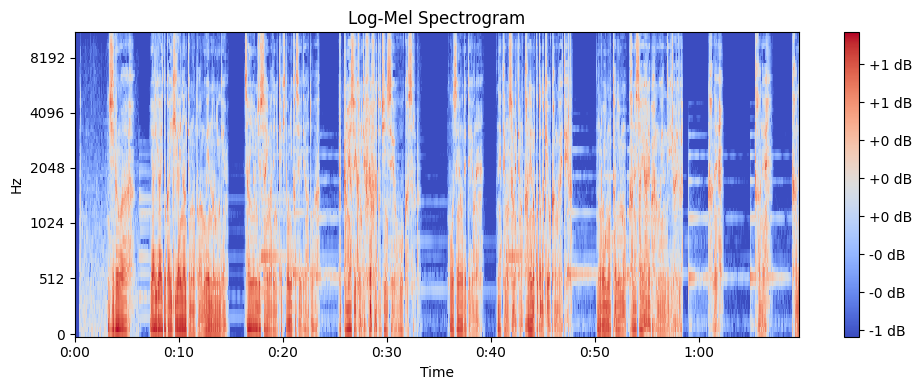

In [11]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel.cpu().numpy(), x_axis='time', y_axis='mel')
plt.title('Log-Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

## Detect language

In [ ]:
# detect the spoken language
_, probs = model.detect_language(mel)
print(f"Detected language: {max(probs, key=probs.get)}")

## Transcript and Translate

In [ ]:
# decode the audio and print
original_options = whisper.DecodingOptions()
translate_options = whisper.DecodingOptions(task="translate")

original_result = whisper.decode(model, mel, original_options)
translate_result = whisper.decode(model, mel, translate_options)

print("Original: " + original_result.text)
print("Translate: " + translate_result.text)

## Translate to Thai

In [ ]:
en2th = Translate('en', 'th')
th_text = en2th.translate(translate_result.text)

print("Translated Thai: " + th_text)

## Import VITS model

In [ ]:
vits_tokenizer = VitsTokenizer.from_pretrained("facebook/mms-tts-tha")
vits_model = VitsModel.from_pretrained("facebook/mms-tts-tha")

In [ ]:
# UROMAN tokenizer check
print(vits_tokenizer.is_uroman)

## Generate sound

In [ ]:
inputs = vits_tokenizer(text=th_text, return_tensors="pt")

set_seed(21)  # make deterministic

with torch.no_grad():
   outputs = vits_model(inputs["input_ids"])

waveform = outputs.waveform[0]

## Preview

In [ ]:
Audio(waveform, rate=vits_model.config.sampling_rate)